In [170]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
from sklearn.cluster import MiniBatchKMeans
from scipy.ndimage import gaussian_filter
from skimage.morphology import binary_closing, binary_opening
from skimage import measure

from load_image import load_image
from diamond import diamond

### Image Preprocess

A given carmera RGB image is preprocessed to reduce the features. First a gaussian filter blurs the imaage to make the road surface look even, and converted to black and white. Finally, using a principal component anlaysis, we reduce the intrinsic dimensionality to attain 99.5% varaince. 

#### PCA

In [171]:
import numpy as np

class ImgCompression(object):
    def __init__(self):
        pass

    def svd(self, X):
        """
        Do SVD. You could use numpy SVD.
        Your function should be able to handle black and white
        images (N x D arrays) as well as color images (N x D x 3 arrays)
        In the image compression, we assume that each colum of the image is a feature. Image is the matrix X.
        Args:
            X: N x D array corresponding to an image (N x D x 3 if color image)
        Return:
            U: N x N (N x N x 3, for color images)
            S: min(N, D) x 1 (min(N, D) x 3, for color images)
            V: D x D (D x D x 3, for color images)
        """
        # First check if it is color or black-white
        if (X.ndim==3) : 
            transposed_img = np.transpose(X,(2,0,1))
            U,S,V = np.linalg.svd(transposed_img, full_matrices=True)
            U = np.transpose(U, (1,2,0))
            S = np.transpose(S)
            V = np.transpose(V, (1,2,0))
            
        else :
            U,S,V = np.linalg.svd(X, full_matrices=True)
        
        return U,S,V

    def rebuild_svd(self, U, S, V, k):
        """
        Rebuild SVD by k componments.
        Args:
            U: N x N (N x N x 3, for color images)
            S: min(N, D) x 1 (min(N, D) x 3, for color images)
            V: D x D (D x D x 3, for color images)
            k: int corresponding to number of components
        Return:
            Xrebuild: N x D array of reconstructed image (N x D x 3 if color image)

        Hint: numpy.matmul may be helpful for reconstructing color images
        """
        
        N = U.shape[0]
        D = V.shape[0]

        if (U.ndim==3):
            depth = 3
            S = np.transpose(S)
            U = np.transpose(U,(2,0,1))
            V = np.transpose(V,(2,0,1))
            
        
            Sigma = np.zeros((depth, N, D))
            for j in range(depth):
                diagS = np.diag(S[j,:])
                Sigma[j,0:k,0:k] = diagS[0:k,0:k]
                
            Xrebuild = U @ Sigma @ V
            Xrebuild = np.transpose(Xrebuild, (1,2,0))
            
        else :
            Sigma = np.zeros((N, D))
            diagS = np.diag(S)
            Sigma[0:k,0:k] = diagS[0:k,0:k]
            Xrebuild = U @ Sigma @ V
            
        return Xrebuild
    
    def compression_ratio(self, X, k):
        """
        Compute compression of an image: (num stored values in compressed)/(num stored values in original)
        Args:
            X: N x D array corresponding to an image (N x D x 3 if color image)
            k: int corresponding to number of components
        Return:
            compression_ratio: float of proportion of storage used by compressed image
        """
        N = X.shape[0]
        D = X.shape[1]
        
        original_values = N*D
        
        compressed_values = k*(1+N+D)
        
        return compressed_values/original_values


    def recovered_variance_proportion(self, S, k): 
        """
        Compute the proportion of the variance in the original matrix recovered by a rank-k approximation

        Args:
           S: min(N, D) x 1 (min(N, D) x 3 for color images) of singular values for the image
           k: int, rank of approximation
        Return:
           recovered_var: int (array of 3 ints for color image) corresponding to proportion of recovered variance
        """
        variance = np.power(S,2)
        if (S.ndim==2):
            depth = 3
            r = np.zeros(depth)
        
            for i in range(depth):
                total_sum = np.sum(variance[:,i])
                rank_k = variance[0:k+1,i]
                rank_k_sum  = np.sum(rank_k)
                r[i] = rank_k_sum/ total_sum
        
        else :
            depth =1
            total_sum = np.sum(variance)
            rank_k = variance[0:k+1]
            rank_k_sum  = np.sum(rank_k)
            r= rank_k_sum/ total_sum
        
        return r
        

In [172]:
imgcomp = ImgCompression()

def pca(X):
    """
    Decompose dataset into principal components. 
    You may use your SVD function from the previous part in your implementation.

    Args: 
        X: N x D array corresponding to a dataset, in which N is the number of points and D is the number of features
    Return:
        U: N x N 
        S: min(N, D) x 1 
        V: D x D
    """
    return imgcomp.svd(X)

def intrinsic_dimension(S, recovered_variance=.99):
    """
    Find the number of principal components necessary to recover given proportion of variance

    Args: 
        S: 1-d array corresponding to the singular values of a dataset

        recovered_varaiance: float in [0,1].  Minimum amount of variance 
            to recover from given principal components
    Return:
        dim: int, the number of principal components necessary to recover 
            the given proportion of the variance
    """
    
    recovered = np.zeros((3))
    recovered_variance_rgb = np.array([recovered_variance,recovered_variance,recovered_variance])
    k= 0
    while all(recovered < recovered_variance_rgb) :
        recovered = imgcomp.recovered_variance_proportion(S, k)
        k= k+1
        
    return k

def num_linearly_ind_features(S, eps=1e-11):
    """
    Find the number of linearly independent features in dataset

    Args: 
        S: 1-d array corresponding to the singular values of a dataset
    Return:
        dim: int, the number of linearly independent dimensions in our data
    """
    return np.sum(S > eps)

def apply_PCA(X, retained_variance=0.995):
    """
    Apply the functions you just implemented
    Args: 
        X: N x D array corresponding to a dataset, in which N is the number of points and D is the number of features
        retained variance: floating number
    Return:
        (X_new, num_linearly_ind_features, intrinsic_dimension): The X projection on the new feature space, the number of linearly independent dimensions in our data, the intrinsic dimension
    """
    
#     X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    U,S,V = imgcomp.svd(X)
    k = intrinsic_dimension(S, retained_variance)
    features= num_linearly_ind_features(S)
    X_new = imgcomp.rebuild_svd(U, S, V, k)
    
    return X_new, features, k

#### Preprocessing autorally images and K-Mean clustered output map labels

In [173]:
def preprocess_image(im):
    
    # Gaussian blur to make the road surface look more even
    im_blur = gaussian_filter(im, sigma=1)
  
    im_bw = np.dot(im_blur[...,:3], [0.299, 0.587, 0.114])
    pca_im,features,k = apply_PCA(im_bw)
    X = pca_im.flatten()
    return X


In [174]:
def preprocess_true_label(im):
    
    Y = im.flatten(-1,1)
    return Y

#### Sample preprocessed image


Text(0.5, 1.0, 'Processed')

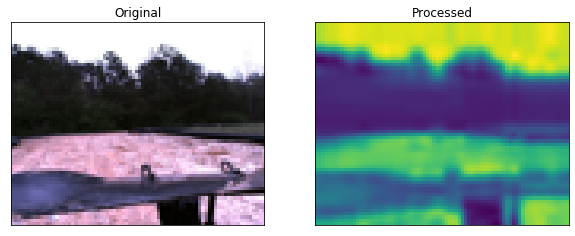

In [175]:
im = load_image('../output/resized/img1264.png')
i,j,k = im.shape

pr_im = preprocess_image(im)
pr_im = pr_im.reshape((i,j))


fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(im)
ax.set_title("Original")
             
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(pr_im)
ax.set_title("Processed")

In [176]:
# Here the flattened image pixel RGB values, state, control are concatenated to generate X. 

import glob
from tqdm import tqdm

image_names = glob.glob('../output/resized/img*.png')
images = []

for image in tqdm(image_names):
    im = load_image(image)
    post_im = preprocess_image(im)
    images.append(post_im)


100%|██████████| 3601/3601 [00:28<00:00, 125.66it/s]


In [177]:
# Now collect all labeled map to generate Y. 

import glob
from tqdm import tqdm

map_names = glob.glob('../output/map/img*.png')
maps = []

for image in tqdm(map_names):
    im = load_image(image)
    post_im = im.flatten()
    maps.append(post_im)



100%|██████████| 3601/3601 [00:03<00:00, 1025.65it/s]


####  State and control concatenation from autorally data


In [178]:
from numpy import genfromtxt

states = genfromtxt('states.csv', delimiter=',')
controls = genfromtxt('controls.csv', delimiter=',')

# state 6x3601 + control 2x3601 = 8 x 3601
# Xall : NxD where N is number of data points =3601, D = dimensions
Xall = np.transpose(np.concatenate((states,controls),axis=0))

# Concatenate image to augment D with image pixels
flattend_images = np.asarray(images, dtype=np.uint8)
Xall = np.concatenate((Xall, flattend_images),axis=1)
print(Xall.shape)

Yall = np.asarray(maps, dtype=np.uint8)
print(Yall.shape)

(3601, 5128)
(3601, 5120)


### Ridge Regression

In [179]:
import numpy as np

class Regression(object):
    
    def __init__(self):
        pass
    
    def rmse(self, pred, label):
        '''
        This is the root mean square error.
        Args:
            pred: numpy array of length N x M, the prediction of labels
            label: numpy array of length N x M, the ground truth of labels
        Return:
            a float value
        '''
        N = pred.shape[0]
        M = pred.shape[1]
        return np.square(np.sum(np.power(pred-label,2))/(N*M))
        
    
    def predict(self, xtest, weight): 
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: DxM numpy array, the weights of linear regression model
        Return:
            prediction: NxM numpy array, the predicted labels
        """
        return np.dot(xtest,weight)

    # =================
    # LINEAR REGRESSION
    # Hints: in the fit function, use close form solution of the linear regression to get weights. 
    # For inverse, you can use numpy linear algebra function  
    # For the predict, you need to use linear combination of data points and their weights (y = theta0*1+theta1*X1+...)

    def linear_fit_closed(self, xtrain, ytrain):
        """
        Args:
            xtrain: N x D numpy array, where N is number of instances and D is the dimensionality of each instance
            ytrain: N x 1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        pinv = np.linalg.pinv(xtrain)
        theta = np.matmul(pinv,ytrain)
        return theta
        

    def linear_fit_GD(self, xtrain, ytrain, epochs=5, learning_rate=0.001): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N = xtrain.shape[0]
        D = xtrain.shape[1]
        theta = np.zeros((D,1))
        i = 0

        while i< epochs:
            xi_theta = np.dot(xtrain, theta)
            diff =learning_rate/N * np.matmul( np.transpose(xtrain),(ytrain-xi_theta))
            theta = theta + diff
            i = i+1    
            
            
        return theta

    def linear_fit_SGD(self, xtrain, ytrain, epochs=100, learning_rate=0.001): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N = xtrain.shape[0]
        D = xtrain.shape[1]
        theta = np.zeros((D,1))
        i = 0
        
        while i< epochs:
            for n in range(N):
                random_x = xtrain[n,:]
                random_y = ytrain[n]
                random_x = random_x.reshape(D,1)
                xi_theta = np.dot(np.transpose(random_x), theta)
                diff =learning_rate * random_x*(random_y-xi_theta)
                theta = theta + diff

            i = i+1    
            
            
        return theta

    # =================
    # RIDGE REGRESSION
        
    def ridge_fit_closed(self, xtrain, ytrain, c_lambda): # [5pts]
        """
        Args:
            xtrain: N x D numpy array, where N is number of instances and D is the dimensionality of each instance
            ytrain: N x 1 numpy array, the true labels
            c_lambda: floating number
        Return:
            weight: Dx1 numpy array, the weights of ridge regression model
        """
        c_lambda =c_lambda + 1e-7
        D = xtrain.shape[1]
        ridge_matrix = np.eye(D)
        ridge_matrix[0,0]=0
        ridged  = np.matmul(np.transpose(xtrain),xtrain) + c_lambda*ridge_matrix
        theta = np.linalg.inv(ridged) @ np.transpose(xtrain) @ ytrain

        return theta

        
    def ridge_fit_GD(self, xtrain, ytrain, c_lambda, epochs=500, learning_rate=1e-7): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: NxM numpy array, the true labels
            c_lambda: floating number
        Return:
            weight: DxM numpy array, the weights of linear regression model
        """
        N = xtrain.shape[0]
        D = xtrain.shape[1]
        M = ytrain.shape[1]
        theta = np.zeros((D,M))

        i = 0

        while i< epochs:
            xi_theta = np.dot(xtrain, theta)
            diff =learning_rate/N * (np.matmul( np.transpose(xtrain),(ytrain-xi_theta)) - c_lambda * theta )
            theta = theta + diff
            i = i+1    
            
            
        return theta

    def ridge_fit_SGD(self, xtrain, ytrain, c_lambda, epochs=1000, learning_rate=1e-2):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: NxM numpy array, the true labels
        Return:
            weight: DxM numpy array, the weights of linear regression model
        """

        N = xtrain.shape[0]
        D = xtrain.shape[1]
        M = ytrain.shape[1]
        theta = np.zeros((D,M))
        i = 0
        
        while i< epochs:
            for n in range(N):
                random_x = xtrain[n,:]
                random_y = ytrain[n,:]
                random_x = random_x.reshape(D,1)
                xi_theta = np.dot(np.transpose(random_x), theta)
                diff =learning_rate * (  random_x*(random_y-xi_theta) - c_lambda*theta)
                theta = theta + diff
                
                
            i = i+1    
            
            
        return theta
    

    def ridge_cross_validation(self, X, y, kfold=10, c_lambda=100): # [8 pts]
        """
        Args:
            X: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            y: Nx1 numpy array, the true labels
            kfold: integer, size of the fold for the data split
            c_lambda: floating number
        Return:
            mean_error: the mean of the RMSE for each fold
        """
        N = X.shape[0]
        
        indices = np.arange(N)
        splited_indices = np.array_split(indices,kfold);
        
        test_rmse = 0 
        
        for i in range(kfold):
            test_indices = splited_indices[i]
            train_indices = indices[~np.in1d(indices, test_indices)]
            
            
            xtrain = X[train_indices, :]
            ytrain = y[train_indices]
            xtest  = X[test_indices,:]
            ytest  = y[test_indices]

            weight = self.ridge_fit_closed(xtrain, ytrain, c_lambda)

            y_test_pred = self.predict(xtest, weight)
            test_rmse = test_rmse + self.rmse(y_test_pred, ytest)
            
        test_rmse = test_rmse/kfold
        
        return test_rmse


### Training ridge regression weight

In [180]:
# Split data into two parts, 
NUM_OBS = 3601

rng = np.random.RandomState(seed=4)

indices = rng.permutation(NUM_OBS)


train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]


In [181]:

reg = Regression()

weight = reg.ridge_fit_closed(Xall[train_indices], Yall[train_indices], c_lambda=100)
# weight = reg.ridge_fit_GD(Xtrain[train_indices], Ytrain[train_indices], c_lambda=1000, epochs=500, learning_rate=1e-7)
# weight = reg.ridge_fit_SGD( c_lambda=100, epochs=500, learning_rate=1e-7)


y_train_pred = reg.predict(Xall[train_indices,:], weight)
train_rmse = reg.rmse(y_train_pred, Yall[train_indices,:])
print('train rmse: %.4f' % train_rmse)

y_test_pred = reg.predict(Xall[test_indices,:], weight)
test_rmse = reg.rmse(y_test_pred, Yall[test_indices,:])
print('test rmse: %.4f' % test_rmse)

train rmse: 1388310.6401
test rmse: 27732542.6936


### Cross Validation to determine best Lambda

In [150]:
# We provided 6 possible values for lambda, and you will use them in cross validation.
# For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
# For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
# At the end for each lambda, you have caluclated 10 rmse and get the mean value of that.
# That's it. Pick up the lambda with the lowest mean value of rmse. 
# Hint: np.concatenate is your friend.

best_lambda = None
best_error = None
kfold = 10
lambda_list = [0, 0.1, 1, 5, 10, 100, 1000]
# lambda_list = [1e10, 1e11, 1e12, 1e13]
for lm in lambda_list:
    err = reg.ridge_cross_validation(Xall[train_indices], Yall[train_indices], kfold, lm)
    print('lambda: %.2f' % lm, 'error: %.6f'% err)
    if best_error is None or err < best_error:
        best_error = err
        best_lambda = lm

print('best_lambda: %.2f' % best_lambda)
weight = reg.ridge_fit_closed(Xall[train_indices], Yall[train_indices], best_lambda)
y_test_pred = reg.predict(Xall[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, Yall[test_indices])
print('test rmse: %.4f' % test_rmse)  

lambda: 0.00 error: 5898853874206344902378258432.000000
lambda: 0.10 error: 1309015704679.418457
lambda: 1.00 error: 37991115.461577
lambda: 5.00 error: 52875921.723183
lambda: 10.00 error: 35759907.888455
lambda: 100.00 error: 33983044.365093
lambda: 1000.00 error: 36330725.134418
best_lambda: 100.00
test rmse: 27732542.6936


### Results : predicted road labels

In [182]:
def post_process(prediction):
    max_val = np.max(prediction)
    
    normalized = prediction/max_val*255
    y_pred = prediction.reshape((64,80))
    
    return y_pred

In [222]:
import glob
from tqdm import tqdm

image_names = glob.glob('../output/resized/img*.png')
images = []
road_masks = []
road_overlays = []
index = 0

for image in tqdm(image_names):
    im = load_image(image)
    y_pred = reg.predict(Xall[index,:],weight)
    road_mask = post_process(y_pred)
    
    im_with_mask = copy.copy(im)
    threshold = road_mask > 30
    i,j = road_mask.shape
    road_mask[~threshold] = 0
    road_mask[threshold] = 255
    colored_mask = np.zeros((i,j,3))
    colored_mask[:,:,2] = road_mask
    
    im_with_mask[threshold] = colored_mask[threshold]
    images.append(im)
    road_masks.append(road_mask)
    road_overlays.append(im_with_mask)
    index = index+1
    

100%|██████████| 3601/3601 [01:14<00:00, 48.22it/s]


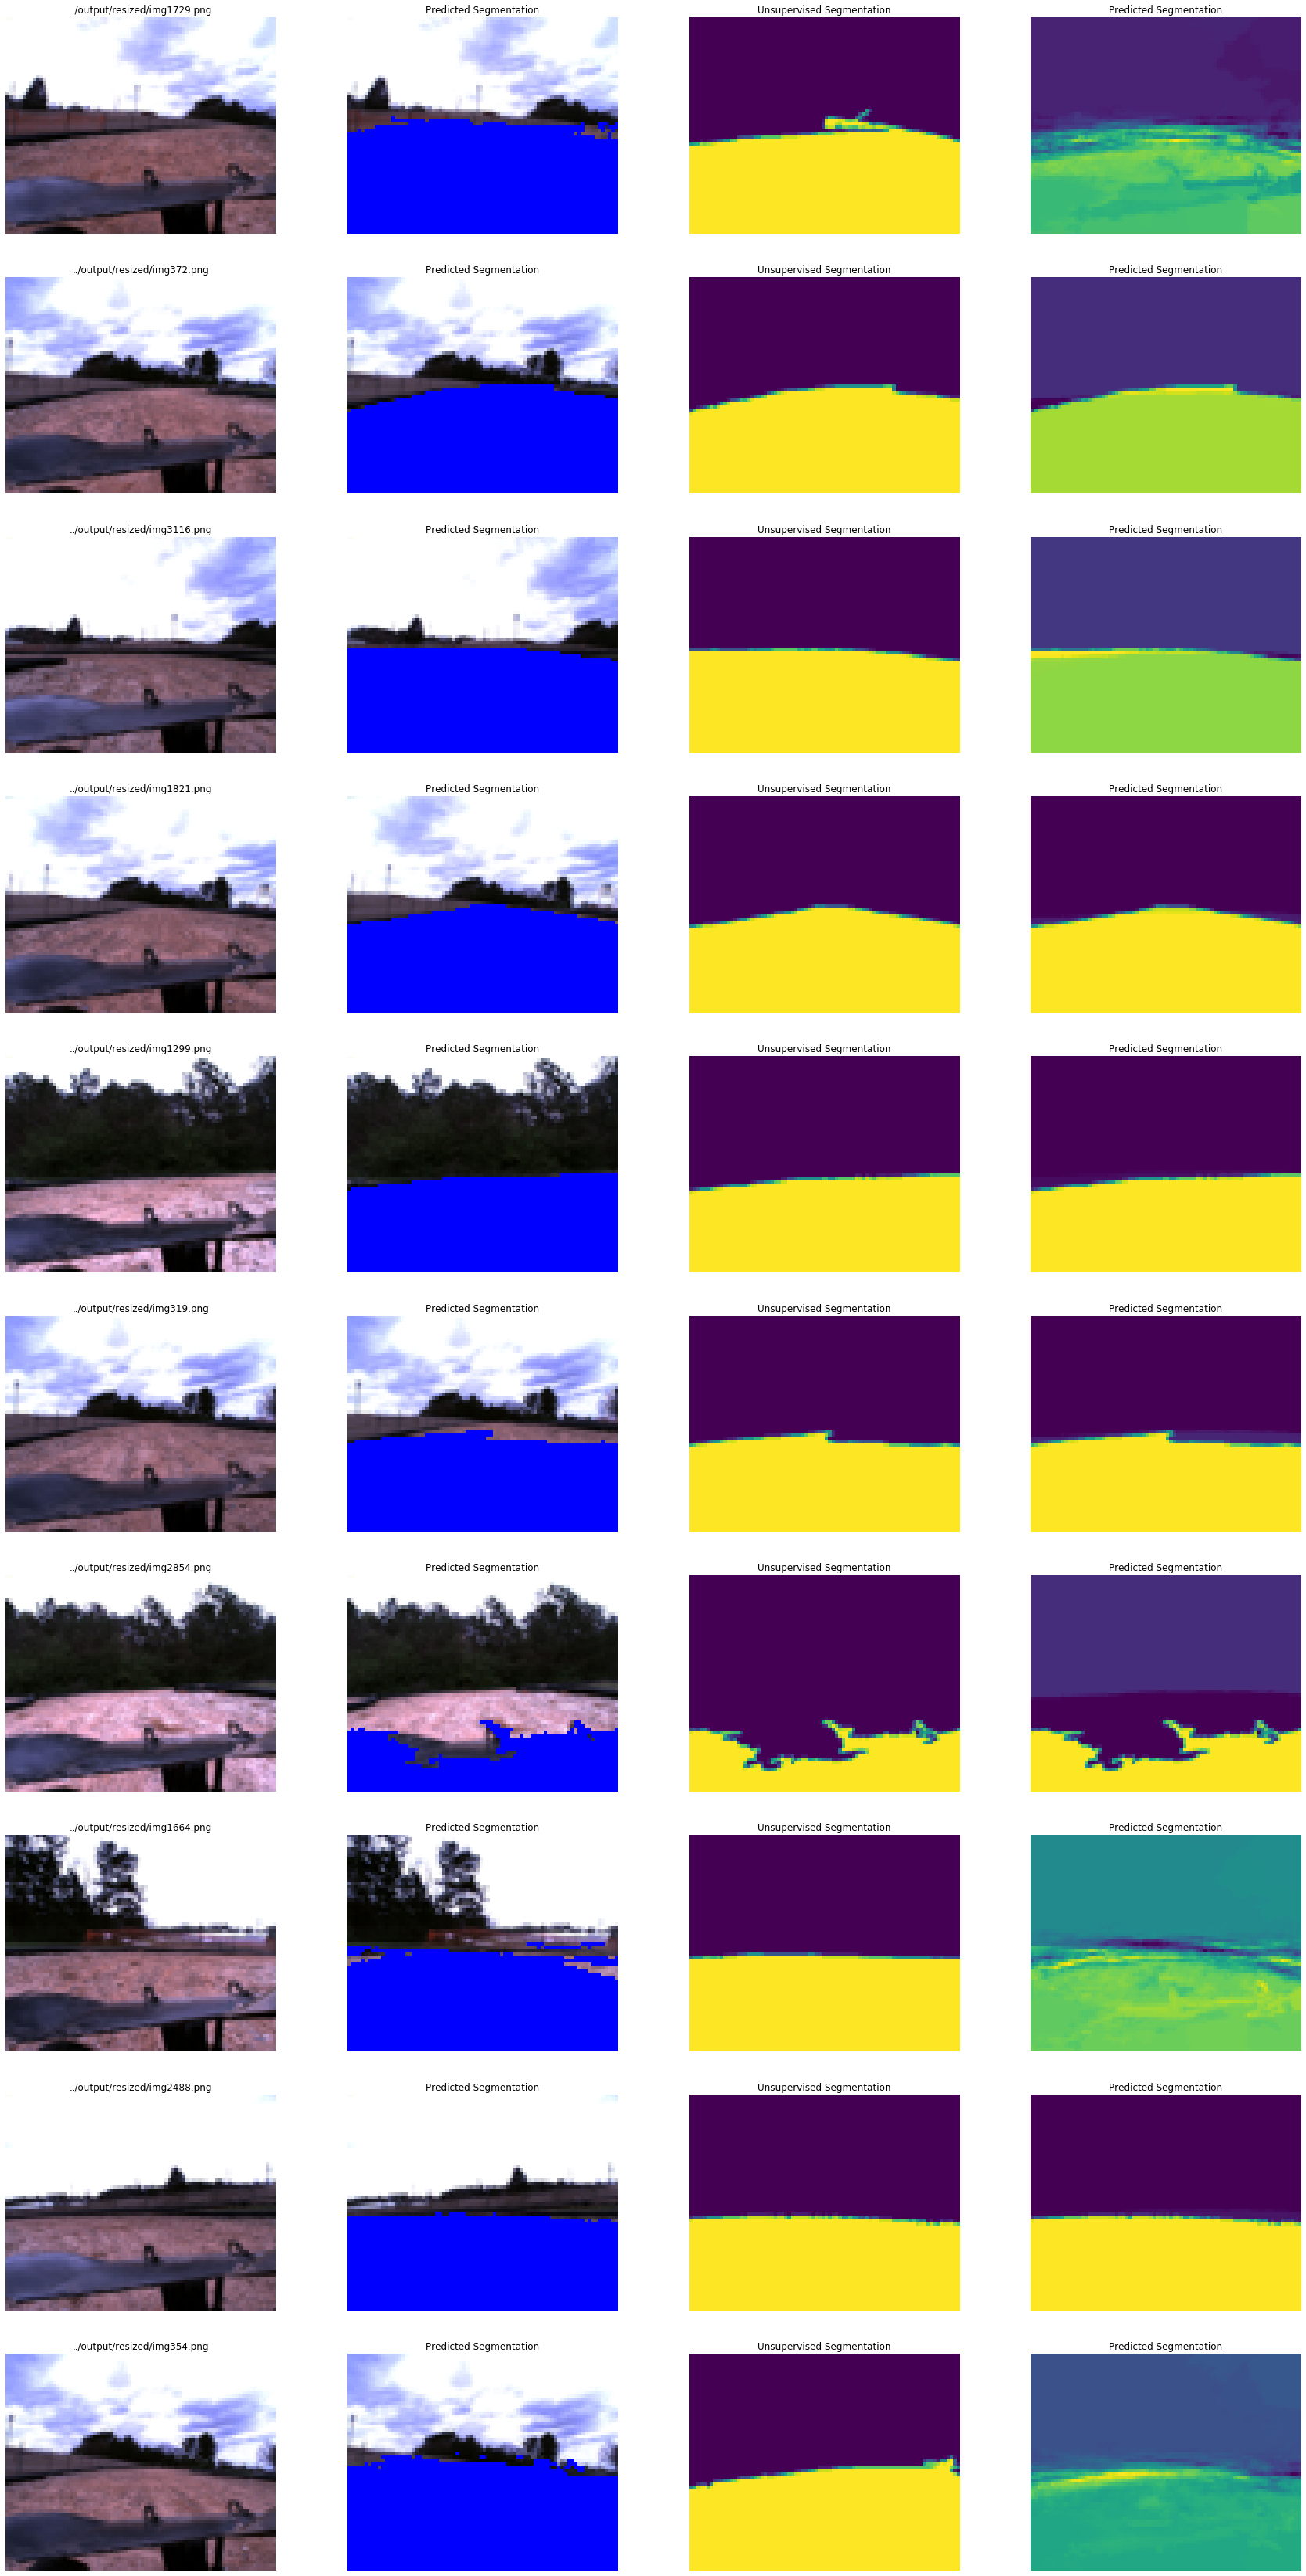

In [226]:
import matplotlib.pyplot as plt
import copy

total_cases = 10
showcases = np.random.randint(3601, size=total_cases)
fig, ax = plt.subplots(total_cases, 4)
fig.set_figheight(60)
fig.set_figwidth(30)

for r in range(len(showcases)):
    ax[r, 0].set_title(image_names[showcases[r]])
    ax[r, 0].imshow(images[showcases[r]])
    ax[r, 0].axis('off')

    ax[r, 1].set_title('Predicted Segmentation')
    ax[r, 1].imshow(road_overlays[showcases[r]])
    ax[r, 1].axis('off')
    
    y_real = Yall[showcases[r],:]
    y_real = y_real.reshape((64,80))
    y_pred= reg.predict(Xall[showcases[r],:], weight)
    y_pred = y_pred.reshape((64,80))
    
    ax[r, 2].set_title('Unsupervised Segmentation')
    ax[r, 2].imshow(y_real)
    ax[r, 2].axis('off')
    
    ax[r, 3].set_title('Predicted Segmentation')
    ax[r, 3].imshow(y_pred)
    ax[r, 3].axis('off')  
    